# Summary

## Task

To explore dependency parsing for sentences so that word level graphs can be constructed for the problem of classification

1. Explore how dependency parsing works
2. Tokenize sentences and give them to the dependency parser
3. Obtain the relationships and check them
4. Convert the dependency graphs from the parser into the graphs that can be used for GCN
5. Explore GCN and try to build graphs from the parsed dependency graphs
6. Perform graph level classification
7. Check performance
8. Refine the various layers and hyperparameters in the process
9. Check final performance
10. Do interpreation manually on some selected examples
11. Implement edge masking to get the minimum subgraph
12. Performe automatic interpretation of the graphs to determine the most important terms/relationships for each sentence

## Method

* For dependency parsing, we will try to use the tools from the stanford nlp group.
* The *[CoreNLP](https://github.com/stanfordnlp/CoreNLP)* library is important as it contains many of the tools needed to performe dependency parsing
* The *[stanza](https://github.com/stanfordnlp/stanza)* library offers a wrapped version of CoreNLP that works directly with Python
* Visualization of the graphs can be done using *[networkx](https://github.com/networkx/networkx)*
* For GCN and word-level graphs we will primarily look at the ideas in this *[tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html)*
* We will try to use the *[spektral](https://github.com/danielegrattarola/spektral/)* library to implement the graphs convolution and attention 
* *[Link](https://universaldependencies.org/u/dep/)* to explaination of dependency relations.

## Dataset

The dataset is still IMDB review but we may expand later on

## Results

Fill in later

## Conclusion

Fill in at the end

# Code

## Basic Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stanza
import networkx as nx
import spacy
import stanzaTools
stanza.download('en')

## Part 1: Dependency Parsing

### Testing Stanza

In [81]:
sampleSentence = "There is nothing wrong with Apple's new M1 Max Chip, everything works so well! Ok this might be kind of difficult."

In [82]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

2022-06-04 14:49:20 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-06-04 14:49:20 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |
| sentiment | sstplus  |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |
| sentiment | sstplus  |

2022-06-04 14:49:20 INFO: Use device: cpu
INFO:stanza:Use device: cpu
2022-06-04 14:49:20 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2022-06-04 14:49:20 INFO: Loading: pos
INFO:stanza:Loading: pos
2022-06-04 14:49:20 INFO: Loading: lemma
INFO:stanza:Loading: lemma
2022-06-04 14:49:20 INFO: Loading: depparse
INFO:stanza:Loading: depparse
2022-06-04 14:49:20 INFO: Loading: sentiment
INFO:stanza:Loading: se

In [83]:
doc = nlp(sampleSentence)

In [84]:
doc.sentences[0]

[
  {
    "id": 1,
    "text": "There",
    "lemma": "there",
    "upos": "PRON",
    "xpos": "EX",
    "head": 2,
    "deprel": "expl",
    "start_char": 0,
    "end_char": 5
  },
  {
    "id": 2,
    "text": "is",
    "lemma": "be",
    "upos": "VERB",
    "xpos": "VBZ",
    "feats": "Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin",
    "head": 0,
    "deprel": "root",
    "start_char": 6,
    "end_char": 8
  },
  {
    "id": 3,
    "text": "nothing",
    "lemma": "nothing",
    "upos": "PRON",
    "xpos": "NN",
    "feats": "Number=Sing",
    "head": 2,
    "deprel": "nsubj",
    "start_char": 9,
    "end_char": 16
  },
  {
    "id": 4,
    "text": "wrong",
    "lemma": "wrong",
    "upos": "ADJ",
    "xpos": "JJ",
    "feats": "Degree=Pos",
    "head": 3,
    "deprel": "amod",
    "start_char": 17,
    "end_char": 22
  },
  {
    "id": 5,
    "text": "with",
    "lemma": "with",
    "upos": "ADP",
    "xpos": "IN",
    "head": 10,
    "deprel": "case",
    "start_char": 23,


In [85]:
sent_dict = doc.sentences[0].to_dict()

#### tokenRelationHead

In [86]:
stanzaTools.tokenRelationHead(sent_dict)

Token           | Relation   | Head            
--------------------------------------------------
There           | expl       | is              
is              | root       | ROOT            
nothing         | nsubj      | is              
wrong           | amod       | nothing         
with            | case       | Max             
Apple           | nmod:poss  | Max             
's              | case       | Apple           
new             | amod       | Max             
M1              | compound   | Max             
Max             | nmod       | nothing         
Chip            | flat       | Max             
,               | punct      | works           
everything      | nsubj      | works           
works           | parataxis  | is              
so              | advmod     | well            
well            | advmod     | works           
!               | punct      | is              


#### getNodeEdgeLists

In [87]:
nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)

In [88]:
doc

[
  [
    {
      "id": 1,
      "text": "There",
      "lemma": "there",
      "upos": "PRON",
      "xpos": "EX",
      "head": 2,
      "deprel": "expl",
      "start_char": 0,
      "end_char": 5
    },
    {
      "id": 2,
      "text": "is",
      "lemma": "be",
      "upos": "VERB",
      "xpos": "VBZ",
      "feats": "Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin",
      "head": 0,
      "deprel": "root",
      "start_char": 6,
      "end_char": 8
    },
    {
      "id": 3,
      "text": "nothing",
      "lemma": "nothing",
      "upos": "PRON",
      "xpos": "NN",
      "feats": "Number=Sing",
      "head": 2,
      "deprel": "nsubj",
      "start_char": 9,
      "end_char": 16
    },
    {
      "id": 4,
      "text": "wrong",
      "lemma": "wrong",
      "upos": "ADJ",
      "xpos": "JJ",
      "feats": "Degree=Pos",
      "head": 3,
      "deprel": "amod",
      "start_char": 17,
      "end_char": 22
    },
    {
      "id": 5,
      "text": "with",
      "lemma":

In [89]:
nodeList

[{'id': 1,
  'text': 'There',
  'lemma': 'there',
  'upos': 'PRON',
  'xpos': 'EX',
  'head': 2,
  'deprel': 'expl',
  'start_char': 0,
  'end_char': 5},
 {'id': 2,
  'text': 'is',
  'lemma': 'be',
  'upos': 'VERB',
  'xpos': 'VBZ',
  'feats': 'Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin',
  'head': 0,
  'deprel': 'root',
  'start_char': 6,
  'end_char': 8},
 {'id': 3,
  'text': 'nothing',
  'lemma': 'nothing',
  'upos': 'PRON',
  'xpos': 'NN',
  'feats': 'Number=Sing',
  'head': 2,
  'deprel': 'nsubj',
  'start_char': 9,
  'end_char': 16},
 {'id': 4,
  'text': 'wrong',
  'lemma': 'wrong',
  'upos': 'ADJ',
  'xpos': 'JJ',
  'feats': 'Degree=Pos',
  'head': 3,
  'deprel': 'amod',
  'start_char': 17,
  'end_char': 22},
 {'id': 5,
  'text': 'with',
  'lemma': 'with',
  'upos': 'ADP',
  'xpos': 'IN',
  'head': 10,
  'deprel': 'case',
  'start_char': 23,
  'end_char': 27},
 {'id': 6,
  'text': 'Apple',
  'lemma': 'Apple',
  'upos': 'PROPN',
  'xpos': 'NNP',
  'feats': 'Number=Sing

#### drawDepGraph

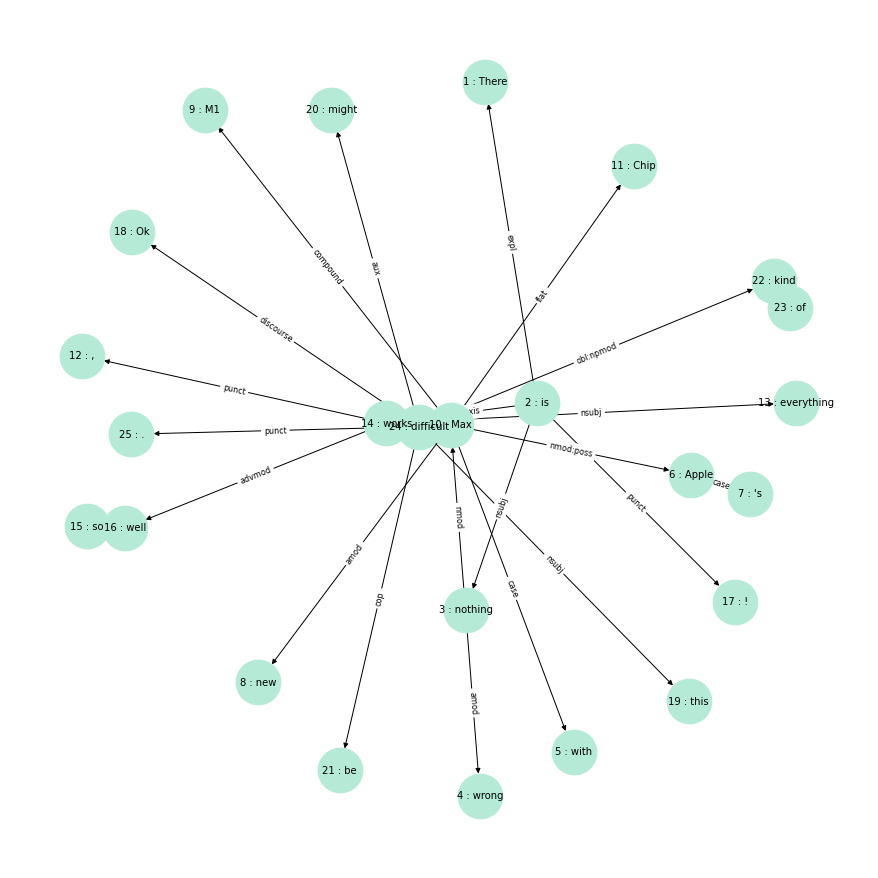

In [90]:
stanzaTools.drawDepGraph(nodeList, edgeList)

### Testing Spacy (Ignore for Now)

In [ ]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

# Process whole documents
text = sampleSentence
doc = nlp(text)
# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)    

In [ ]:
spacy.displacy.render(doc, style='dep', jupyter=True, options={'distance': 120})

In [ ]:
doc

### Testing TF Datasets

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import spacy
import tfDatasetTools
nlp = spacy.load("en_core_web_sm")

In [ ]:
trainDS = tfds.load('imdb_reviews', split='train', as_supervised=True, shuffle_files=True)
testDS = tfds.load('imdb_reviews', split='test', as_supervised=True, shuffle_files=True)

In [ ]:
part = testDS.take(10)

#### decodeZeroDimTensor

#### convertTakeDataset

In [ ]:
features, labels = tfDatasetTools.convertTakeDataset(part)

In [ ]:
features[0]

In [ ]:
labels

In [ ]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

In [ ]:
doc = nlp(features[1])
for sentence in doc.sentences:
    print(sentence.text)
    print(sentence.sentiment)

In [ ]:
doc.sentences[1]

### Testing spektral

In [ ]:
import spektral
from spektral.datasets import TUDataset

In [ ]:
dataset = TUDataset('PROTEINS')

In [ ]:
dataset

In [ ]:
train_datset = dataset[:100]

In [ ]:
test_datset = dataset[100:]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from spektral.layers import GCNConv, GlobalSumPool

In [ ]:
class MyFirstGNN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden)
        self.pool = GlobalSumPool()
        self.dropout = Dropout(0.5)
        self.dense = Dense(n_labels, 'softmax')

    def call(self, inputs):
        out = self.graph_conv(inputs)
        out = self.dropout(out)
        out = self.pool(out)
        out = self.dense(out)

        return out

In [ ]:
model = MyFirstGNN(32, dataset.n_labels)
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from spektral.data import BatchLoader

loader = BatchLoader(train_datset, batch_size=32)
testLoader = BatchLoader(test_datset, batch_size=32)

In [ ]:
model.fit(loader.load(),steps_per_epoch=loader.steps_per_epoch, epochs=10)

In [ ]:
model.evaluate(testLoader.load(),steps=testLoader.steps_per_epoch)

In [ ]:
test_datset[12].y

## Part 2: Graph Networks

### Basic Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stanza
import networkx as nx
import tensorflow_hub as hub
import tensorflow_text
import spektral

In [2]:
import stanzaTools
import tfDatasetTools
import relationEncoder

In [3]:
import io, time, joblib, json

### Set up Stanza

In [4]:
stanza.download('en')

2022-06-04 14:23:07 INFO: Downloading default packages for language: en (English)...
2022-06-04 14:23:08 INFO: File exists: /Users/zeyuyang/stanza_resources/en/default.zip
2022-06-04 14:23:11 INFO: Finished downloading models and saved to /Users/zeyuyang/stanza_resources.


In [5]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

2022-06-04 14:23:11 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-06-04 14:23:12 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |
| sentiment | sstplus  |

2022-06-04 14:23:12 INFO: Use device: cpu
2022-06-04 14:23:12 INFO: Loading: tokenize
2022-06-04 14:23:12 INFO: Loading: pos
2022-06-04 14:23:12 INFO: Loading: lemma
2022-06-04 14:23:12 INFO: Loading: depparse
2022-06-04 14:23:12 INFO: Loading: sentiment
2022-06-04 14:23:12 INFO: Done loading processors!


#### createGraph

In [80]:
from importlib import reload
reload(stanzaTools)
reload(tfDatasetTools)

<module 'tfDatasetTools' from '/Users/zeyuyang/Projects/CS397Project/tfDatasetTools.py'>

In [7]:
relationsDict = relationEncoder.getRelationsDict()

In [8]:
def createGraph(doc, positive):
    startTime = time.perf_counter()
    nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)
    nodeTime = time.perf_counter()
    words = [item['text'] for item in nodeList]
    convertedFeatures = stanzaTools.convertToEmbedding(words, preprocessor, encoder)
    adjacencyMatrix = stanzaTools.createAdjacencyMatrix(edgeList, len(nodeList))
    convertTime = time.perf_counter()
    sortedList = sorted(edgeList, key=lambda x: (x['edgePair'][0], x['edgePair'][1]))
    edgeFeatures = relationEncoder.OneHotEncode(relationsDict, [edge['edgeLabel'] for edge in sortedList])
    encodeTime = time.perf_counter()
    label = np.array([positive])
    print([nodeTime - startTime, convertTime  - nodeTime, encodeTime - convertTime])
    # newGraph = spektral.data.graph.Graph(x=convertedFeatures, a=adjacencyMatrix, y=label)
    return (convertedFeatures, adjacencyMatrix, edgeFeatures, label)

In [9]:
def createCustomGraph(doc, positive):
    startTime = time.perf_counter()
    nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)
    nodeTime = time.perf_counter()
    words = [item['text'] for item in nodeList]
    convertedFeatures = stanzaTools.convertToCustomEmbedding(words, preprocessor, model.layers[2])
    adjacencyMatrix = stanzaTools.createAdjacencyMatrix(edgeList, len(nodeList))
    convertTime = time.perf_counter()
    sortedList = sorted(edgeList, key=lambda x: (x['edgePair'][0], x['edgePair'][1]))
    edgeFeatures = relationEncoder.OneHotEncode(relationsDict, [edge['edgeLabel'] for edge in sortedList])
    encodeTime = time.perf_counter()
    label = np.array([positive])
    print([nodeTime - startTime, convertTime  - nodeTime, encodeTime - convertTime])
    # newGraph = spektral.data.graph.Graph(x=convertedFeatures, a=adjacencyMatrix, y=label)
    return (convertedFeatures, adjacencyMatrix, edgeFeatures, label)

In [95]:
def createCustomGraph2(doc, positive):
    startTime = time.perf_counter()
    nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc)
    nodeTime = time.perf_counter()
    words = [item['text'] for item in nodeList]
    print(len(words))
    convertedFeatures = convertToCustomEmbedding(words)
    adjacencyMatrix = stanzaTools.createAdjacencyMatrix(edgeList, len(nodeList))
    convertTime = time.perf_counter()
    sortedList = sorted(edgeList, key=lambda x: (x['edgePair'][0], x['edgePair'][1]))
    edgeFeatures = relationEncoder.OneHotEncode(relationsDict, [edge['edgeLabel'] for edge in sortedList])
    encodeTime = time.perf_counter()
    label = np.array([positive])
    print([nodeTime - startTime, convertTime  - nodeTime, encodeTime - convertTime])
    # newGraph = spektral.data.graph.Graph(x=convertedFeatures, a=adjacencyMatrix, y=label)
    return (convertedFeatures, adjacencyMatrix, edgeFeatures, label)

#### createGraphAlpha

In [96]:
def createGraphAlpha(doc, positive):
    # startTime = time.perf_counter()
    nodeList, edgeList = stanzaTools.getNodeEdgeLists(doc, False, False)
    # nodeTime = time.perf_counter()
    words = [item['text'] for item in nodeList]
    # print(len(words))
    convertedFeatures = convertToCustomEmbedding(words)
    adjacencyMatrix = stanzaTools.createAdjacencyMatrix(edgeList, len(nodeList))
    # convertTime = time.perf_counter()
    sortedList = sorted(edgeList, key=lambda x: (x['edgePair'][0], x['edgePair'][1]))
    edgeFeatures = relationEncoder.OneHotEncode(relationsDict, [edge['edgeLabel'] for edge in sortedList])
    # encodeTime = time.perf_counter()
    label = np.array([positive])
    # print([nodeTime - startTime, convertTime  - nodeTime, encodeTime - convertTime])
    # newGraph = spektral.data.graph.Graph(x=convertedFeatures, a=adjacencyMatrix, y=label)
    return (convertedFeatures, adjacencyMatrix, edgeFeatures, label)

### Load Data

In [12]:
trainDS = tfds.load('imdb_reviews', split='train', as_supervised=True, shuffle_files=True)
testDS = tfds.load('imdb_reviews', split='test', as_supervised=True, shuffle_files=True)

Metal device set to: Apple M1 Max


2022-06-04 14:23:33.951390: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-04 14:23:33.951752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Set a Limit

In [13]:
trainLimit = 10000
testLimit = 10000

trainSubset = trainDS.take(trainLimit)
testSubset = testDS.take(testLimit)

In [14]:
validationSplit = 0.2
validationIndex = int(validationSplit * trainLimit)

validationSplitSubset = trainSubset.take(validationIndex)
trainSplitSubset = trainSubset.skip(validationIndex)

In [15]:
trainFeatures, trainLabels = tfDatasetTools.convertTakeDataset(trainSplitSubset)
valFeatures, valLabels = tfDatasetTools.convertTakeDataset(validationSplitSubset)
testFeatures, testLabels = tfDatasetTools.convertTakeDataset(testSubset)

2022-06-04 14:23:38.084095: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-04 14:23:38.625361: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-06-04 14:23:38.758509: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-06-04 14:23:39.320074: W t

##### Checking trainFeatures and functions

In [16]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize, mwt')

2022-06-04 14:23:42 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-06-04 14:23:42 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2022-06-04 14:23:42 INFO: Use device: cpu
INFO:stanza:Use device: cpu
2022-06-04 14:23:42 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2022-06-04 14:23:42 INFO: Done loading processors!
INFO:stanza:Done loading processors!


#### Create Custom tokenizer
The goal is to matche our tokenizer to the one used by stanza. The ideas is to first tokenize all of the train+validation reviews into words. Then use our own tokenizer to parse all of these words to learn what the vocabulary is. Later, we will use stanza to break each feature into a list of nodes. The list of nodes will be converted using our own tokenizer into a list of ints. The list of ints will be used to train the embedding model and to create the embeddings for the graph model.

Use joblib with parallel jobs to speed up the processing by about 200%.

In [17]:
def getStanzaProSents(features):
    tokenizedSentences = []
    for feature in features:
        doc = nlp(feature)
        for sentence in doc.sentences:
            tokenizedSentences.append(" ".join([item['text'] for item in sentence.to_dict()]))
    return tokenizedSentences

This takes about 42 seconds per 1000 reviews

In [18]:
startTime = time.perf_counter()
step = 50
totalFeatures = trainFeatures + valFeatures
results = joblib.Parallel(n_jobs=8, prefer="threads")(joblib.delayed(getStanzaProSents)(totalFeatures[i:i + step]) for i in range(0,trainLimit,step))
print(time.perf_counter()-startTime)
deListed = []
for i in results:
    deListed += i

430.31550612500007


In [19]:
customTokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=30000, oov_token='OOVTOKEN', filters='', lower = True, split = ' ')

In [20]:
customTokenizer.fit_on_texts(deListed)

In [22]:
file_path = './tokenizer/token' + str(trainLimit) + '.json'

In [700]:
# use if you want to rewrite the file
tokenizer_json = customTokenizer.to_json()
with io.open(file_path, 'w', encoding='utf-8') as f:
            f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [23]:
with open(file_path) as f:
            data = json.load(f)
            customTokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)

In [24]:
len(customTokenizer.index_word)

54970

In [25]:
one = customTokenizer.texts_to_sequences([trainFeatures[0]])

In [26]:
customTokenizer.sequences_to_texts(one)

["i love this OOVTOKEN every time i watch an episode i repeat that line and remind myself how good of a show this OOVTOKEN i am a huge sci-fi fan and this show has grounds to be the most important science OOVTOKEN show in the history of OOVTOKEN there are so many theories in this show about the universe i could start a OOVTOKEN its OOVTOKEN season after season the show gets better and OOVTOKEN i've been a fan of macgyver since i was 5 OOVTOKEN OOVTOKEN and i find it so ironic that my 2 favorite tv shows of all time star richard dean OOVTOKEN its also interesting how each character is practically the opposite of the OOVTOKEN back when i first saw stargate the OOVTOKEN i instantly liked it and considered it one of my favorite sci-fi OOVTOKEN then hearing a tv show would spin from it i got really OOVTOKEN but didn't get showtime till the fifth season was almost OOVTOKEN OOVTOKEN i'm disappointed to hear that roland emmerich and dean devlin wanted to do a trilogy of movies but the studio o

#### Bert Embeddings

In [27]:
tf.keras.backend.clear_session()

In [411]:
# Preprocess and encode input
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2',trainable=False)

outputs = encoder(encoder_inputs)

pooled_output = outputs['pooled_output'] # [batch_size, 128].
# [batch_size, seq_length, 128].

sequence_output = outputs['sequence_output']

2022-05-29 23:02:06.956843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


##### Sample Convert to BERT Embedding

In [412]:
text = "hello there who are you hello there who are you hello there who are you hello there who are you hello there who are you hello there who are you"
words = text.split()
converted = stanzaTools.convertToEmbedding(words, preprocessor, encoder)

2022-05-29 23:02:11.958773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-29 23:02:12.132296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [413]:
converted.shape

(30, 128)

In [414]:
converted = stanzaTools.convertToEmbedding(['!'], preprocessor, encoder)

In [415]:
word = ['hello', 'there']
convertedWords = stanzaTools.convertToEmbedding(word, preprocessor, encoder)

In [416]:
convertedWords.shape

(2, 128)

#### Training Custom Embeddings

Tokenize and pad the train and val features

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [29]:
MAX_SEQUENCE_LENGTH = 256

In [30]:
xTrain = customTokenizer.texts_to_sequences(trainFeatures)
xTrain = pad_sequences(xTrain, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [31]:
yTrain = np.array(trainLabels)
print(xTrain.shape)
print(yTrain.shape)

(8000, 256)
(8000,)


In [32]:
xValidation = customTokenizer.texts_to_sequences(valFeatures)
xValidation = pad_sequences(xValidation, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [33]:
yValidation = np.array(valLabels)
print(xValidation.shape)
print(yValidation.shape)

(2000, 256)
(2000,)


In [34]:
testLimit = 5000

In [35]:
xTest = customTokenizer.texts_to_sequences(testFeatures[0:testLimit])
xTest = pad_sequences(xTest, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [36]:
yTest = np.array(testLabels[0:testLimit])
print(xTest.shape)
print(yTest.shape)

(5000, 256)
(5000,)


Make the model

In [62]:
def sampleModel():
    sequence_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = tf.keras.layers.Embedding(30000,
                                                16)(sequence_input)
    pool = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
    dense_layer = tf.keras.layers.Dense(16, activation='relu')(pool)
    dropout_layer = tf.keras.layers.Dropout(0.3)(dense_layer)
    outputs = tf.keras.layers.Dense(1)(dropout_layer)

    return tf.keras.Model(inputs=sequence_input, outputs=outputs)

In [63]:
tf.keras.backend.clear_session()
embeddingModel = sampleModel()
embeddingModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 16)           480000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                             

In [64]:
embeddingModel.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [65]:
history = embeddingModel.fit(
    xTrain,
    yTrain,
    validation_data=(xValidation, yValidation),
    epochs=5,
    verbose=1)

Epoch 1/5
  1/250 [..............................] - ETA: 1:07 - loss: 0.6931 - accuracy: 0.5625

2022-06-04 14:39:42.918895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.4996

2022-06-04 14:39:46.931897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 4s 17ms/step - loss: 0.6826 - accuracy: 0.4996 - val_loss: 0.6549 - val_accuracy: 0.5015
Epoch 2/5
250/250 [==============================] - 4s 15ms/step - loss: 0.5562 - accuracy: 0.6714 - val_loss: 0.4838 - val_accuracy: 0.8065
Epoch 3/5
250/250 [==============================] - 3s 14ms/step - loss: 0.3828 - accuracy: 0.8435 - val_loss: 0.3883 - val_accuracy: 0.8410
Epoch 4/5
250/250 [==============================] - 3s 13ms/step - loss: 0.2804 - accuracy: 0.8901 - val_loss: 0.3543 - val_accuracy: 0.8550
Epoch 5/5
250/250 [==============================] - 3s 13ms/step - loss: 0.2153 - accuracy: 0.9236 - val_loss: 0.3453 - val_accuracy: 0.8595


In [66]:
results = embeddingModel.evaluate(x=xTest, y=yTest)

157/157 [==============================] - 1s 4ms/step - loss: 0.3647 - accuracy: 0.8398


##### Sample Convert to Custom Embeddings

In [67]:
embeddingModel.layers[1]

In [68]:
listOfWords = "why did I do this".split()

In [69]:
listOfWords

['why', 'did', 'I', 'do', 'this']

In [70]:
sequence = customTokenizer.texts_to_sequences(listOfWords)

In [71]:
sequence

[[149], [82], [12], [49], [13]]

In [72]:
reshapedSeq = np.array(sequence).reshape((len(sequence),))

In [73]:
reshapedSeq

array([149,  82,  12,  49,  13])

In [74]:
embeddedSeq = embeddingModel.layers[1](reshapedSeq)

In [75]:
np.array(embeddedSeq)

array([[ 0.07890902,  0.19533819, -0.12725225, -0.19173597, -0.12536286,
         0.10662227, -0.21145813, -0.12643147, -0.16109386,  0.20978141,
        -0.15504336,  0.2102495 ,  0.17694837, -0.19372538, -0.18275827,
         0.16654494],
       [ 0.0843708 ,  0.09319644, -0.01497115, -0.07239394, -0.08228982,
         0.06778584, -0.14404279, -0.0796992 , -0.18000685,  0.12080268,
        -0.10378254,  0.1878184 ,  0.10530651, -0.09627914, -0.09801108,
         0.15733153],
       [ 0.07339113, -0.04302793, -0.19533019,  0.07699015,  0.03552973,
        -0.07023028, -0.056678  ,  0.02365462, -0.02302306,  0.00181321,
         0.05270104,  0.00171633, -0.10090076,  0.02338001, -0.05605143,
        -0.0593782 ],
       [ 0.1348524 ,  0.1905593 , -0.15101175, -0.17491458, -0.22634368,
         0.1393976 , -0.18022574, -0.1947141 , -0.21485187,  0.18093476,
        -0.22455978,  0.27268037,  0.1621794 , -0.2532964 , -0.2361159 ,
         0.15330526],
       [ 0.09937557,  0.02251425, -0

#### convertToCustomEmbedding

In [146]:
def convertToCustomEmbedding(words):
    """
    Takes a list of words and converts it to a list of custom embeddings. 

    Args:
        words - (list) The list of words to convert
    Returns:
        embeddings - (list) A list of embeddings
    """
    sequence = customTokenizer.texts_to_sequences(words)
    reshapedSeq = np.array([item[0] for item in sequence])
    try:
        convertedWords = embeddingModel.layers[1](reshapedSeq)
    except:
        print(words)
        print(reshapedSeq)
    return np.array(convertedWords)

### Convert Data to Graph Format

In [77]:
nlp = stanza.Pipeline(
    'en',
    processors = 'tokenize,mwt,pos,lemma,depparse, sentiment')

2022-06-04 14:42:00 WARNING: Can not find mwt: default from official model list. Ignoring it.
2022-06-04 14:42:00 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |
| sentiment | sstplus  |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |
| sentiment | sstplus  |

2022-06-04 14:42:00 INFO: Use device: cpu
INFO:stanza:Use device: cpu
2022-06-04 14:42:00 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2022-06-04 14:42:00 INFO: Loading: pos
INFO:stanza:Loading: pos
2022-06-04 14:42:00 INFO: Loading: lemma
INFO:stanza:Loading: lemma
2022-06-04 14:42:00 INFO: Loading: depparse
INFO:stanza:Loading: depparse
2022-06-04 14:42:00 INFO: Loading: sentiment
INFO:stanza:Loading: se

#### convertToGraph

In [78]:
def convertToGraph(sentence, label):
    doc = nlp(sentence)
    newGraph = createGraphAlpha(doc, label)
    return newGraph

In [124]:
numTrain = len(trainFeatures)
numVal = len(valFeatures)
numTest = 5000

In [125]:
startTime = time.perf_counter()
# trainGraphs = [convertToGraph(trainFeatures[i], trainLabels[i]) for i in range(10)]
trainGraphs = joblib.Parallel(n_jobs=8, prefer="threads")(joblib.delayed(convertToGraph)(trainFeatures[i], trainLabels[i]) for i in range(numTrain))
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

971.1785690419997


In [128]:
[item[0].shape for item in trainGraphs[0:10]]

[(245, 16),
 (443, 16),
 (128, 16),
 (64, 16),
 (133, 16),
 (325, 16),
 (115, 16),
 (199, 16),
 (167, 16),
 (376, 16)]

In [129]:
numVal

2000

In [147]:
startTime = time.perf_counter()
validationGraphs = joblib.Parallel(n_jobs=8, prefer="threads")(joblib.delayed(convertToGraph)(valFeatures[i], valLabels[i]) for i in range(numVal))
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

240.06892058300036


In [148]:
[item.shape for item in validationGraphs[0]]

[(134, 16), (134, 134), (125, 51), (1,)]

In [149]:
startTime = time.perf_counter()
testGraphs = joblib.Parallel(n_jobs=8, prefer="threads")(joblib.delayed(convertToGraph)(testFeatures[i], testLabels[i]) for i in range(numTest))
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

595.6615268330006


In [150]:
[item.shape for item in testGraphs[0]]

[(220, 16), (220, 220), (210, 51), (1,)]

#### Speed test

In [802]:
sentences = []
labels = []
for i in range(10):
    sentence = trainFeatures[i]
    label = trainLabels[i]
    sentences.append(sentence)
    labels.append(label)

In [871]:
for sentence in sentences[0:5]:
    print(sentence[0:100])

I love this show!  Every time i watch an episode i repeat that line and remind myself how good of a 
I gave it a 10, since everyone else seemed to like it and it would have been churlish not to. The re
Considering its pedigree, this should be a far more enjoyable film than it is. Even with a lip-smack
Give this movie a break! Its worth at least a "7"! That little girl is a good actor and she's cute, 
Actually had to stop it. Don't get me wrong, love bad monster movies. But this one was way too borin


In [803]:
import time

In [804]:
startTime = time.perf_counter()
docs = []
for sentence in sentences:
    doc = nlp(sentence)
    docs.append(doc)
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

3.5648865830007708


In [872]:
for doc in docs[0:5]:
    print(doc.sentences[0].text)

I love this show!
I gave it a 10, since everyone else seemed to like it and it would have been churlish not to.
Considering its pedigree, this should be a far more enjoyable film than it is.
Give this movie a break!
Actually had to stop it.


In [873]:
def runDepenParse(sentence):
    return(nlp(sentence))

In [880]:
startTime = time.perf_counter()
parallelDocs = joblib.Parallel(n_jobs=8, prefer="threads")(joblib.delayed(nlp)(sentences[i]) for i in range(len(sentences)))
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

1.400063583991141


In [881]:
for doc in parallelDocs[0:5]:
    print(doc.sentences[0].text)

I love this show!
I gave it a 10, since everyone else seemed to like it and it would have been churlish not to.
Considering its pedigree, this should be a far more enjoyable film than it is.
Give this movie a break!
Actually had to stop it.


In [815]:
performanceTest = []
startTime = time.perf_counter()
for i in range(len(docs)):
    doc = docs[i]
    label = labels[i]
    newGraph = createGraph(doc, label)
    performanceTest.append(newGraph)
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

[0.0016565000114496797, 0.8239069159899373, 4.258399712853134e-05]
[0.0005920830008108169, 0.880328291998012, 5.966699973214418e-05]
[0.0004295000107958913, 0.5279259999952046, 4.3624997488223016e-05]
[0.00021374999778345227, 0.1548051249992568, 2.400000812485814e-05]
[0.0004080420039827004, 0.41955416700511705, 3.466599446255714e-05]
[0.0003648330020951107, 0.38100525000481866, 3.6124998587183654e-05]
[8.412500028498471e-05, 0.050149124988820404, 1.2541000614874065e-05]
[0.00044112501200288534, 0.6078953749965876, 4.849999095313251e-05]
[0.0008354589954251423, 1.7352896660013357, 6.474999827332795e-05]
[0.0004531250015133992, 0.6398550419980893, 4.225000157020986e-05]
6.228190624999115


In [821]:
performanceTest[0][0].shape

(68, 128)

In [823]:
performanceCustomTest = []
startTime = time.perf_counter()
for i in range(len(docs)):
    doc = docs[i]
    label = labels[i]
    newGraph = createCustomGraph(doc, label)
    performanceCustomTest.append(newGraph)
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

2022-05-30 20:44:46.623199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.0014568749902537093, 0.650831000006292, 4.850000550504774e-05]


2022-05-30 20:44:47.259807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.000592500000493601, 1.0497337500128197, 5.037499067839235e-05]


2022-05-30 20:44:48.308816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.00040020800952333957, 0.6706725839903811, 4.2750005377456546e-05]


2022-05-30 20:44:48.981627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.0002625420020194724, 0.2348579579993384, 2.4708002456463873e-05]


2022-05-30 20:44:49.218482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.00036829200689680874, 0.42855179199250415, 3.783300053328276e-05]


2022-05-30 20:44:49.645511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.0003355830122018233, 0.39810258299985435, 3.258399374317378e-05]
[7.166700379457325e-05, 0.10051387498970143, 1.4375007594935596e-05]


2022-05-30 20:44:50.043553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-30 20:44:50.145551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.00044062500819563866, 0.6135991249902872, 4.1000006604008377e-05]


2022-05-30 20:44:50.759863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.0006962500046938658, 1.3325668750039767, 6.137500167824328e-05]


2022-05-30 20:44:52.093539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.0004484169912757352, 0.6950325420039007, 3.9165999623946846e-05]
6.181251499991049


In [834]:
performanceCustomTest[0][0].shape

(68, 10)

In [883]:
performanceCustomTest2 = []
startTime = time.perf_counter()
for i in range(len(docs)):
    doc = docs[i]
    label = labels[i]
    newGraph = createGraphAlpha(doc, label)
    performanceCustomTest2.append(newGraph)
timeElapsed = time.perf_counter() - startTime
print(timeElapsed)

68
91
67
29
56
55
8
69
113
73
0.04741829200065695


In [867]:
performanceCustomTest2[0][0].shape

(68, 10)

In [863]:
Graph(performanceCustomTest2[0][0], performanceCustomTest2[0][1], performanceCustomTest2[0][2], performanceCustomTest2[0][3])

Graph(n_nodes=68, n_node_features=10, n_edge_features=51, n_labels=1)

In [859]:
performanceCustomTest2[0][3]

array([1])

### Custom Graph Datasets

In [153]:
from spektral.data import Dataset 
from spektral.data.graph import Graph
import os

In [154]:
class TrainDataset(Dataset):
    """
    A dataset of train graphs.
    """
    def __init__(self, **kwargs):
        # self.path = savePath
        self.download()
        super().__init__(**kwargs)
    
    def download(self):
        # data = ... 
        # Download from somewhere

        # Create the directory
        try:
            os.mkdir(self.path)
        except:
            pass

        # Write the data to file
        for i in range(len(trainGraphs)):
            x = trainGraphs[i][0]
            a = trainGraphs[i][1]
            e = trainGraphs[i][2]
            y = trainGraphs[i][3]

            filename = os.path.join(self.path, f'graph_{i}')
            np.savez(filename, x=x, a=a, e=e, y=y)
            

    def read(self):
        # We must return a list of Graph objects
        output = []

        for i in range(len(trainGraphs)):
            data = np.load(os.path.join(self.path, f'graph_{i}.npz'), allow_pickle=True)
            # print(data['a'])
            output.append(
                Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
            )
        return output

In [155]:
class ValDataset(Dataset):
    """
    A dataset of val graphs.
    """
    def __init__(self, **kwargs):
        # self.path = savePath
        self.download()
        super().__init__(**kwargs)
    
    def download(self):
        # data = ... 
        # Download from somewhere

        # Create the directory
        try:
            os.mkdir(self.path)
        except:
            pass

        # Write the data to file
        for i in range(len(validationGraphs)):
            x = validationGraphs[i][0]
            a = validationGraphs[i][1]
            e = validationGraphs[i][2]
            y = validationGraphs[i][3]

            filename = os.path.join(self.path, f'graph_val_{i}')
            np.savez(filename, x=x, a=a, e=e, y=y)
            

    def read(self):
        # We must return a list of Graph objects
        output = []

        for i in range(len(validationGraphs)):
            data = np.load(os.path.join(self.path, f'graph_val_{i}.npz'), allow_pickle=True)
            # print(data['a'])
            output.append(
                Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
            )
        return output

In [156]:
class TestDataset(Dataset):
    """
    A dataset of val graphs.
    """
    def __init__(self, **kwargs):
        self.download()
        super().__init__(**kwargs)
    
    def download(self):
        # data = ... 
        # Download from somewhere

        # Create the directory
        try:
            os.mkdir(self.path)
        except:
            pass

        # Write the data to file
        for i in range(len(testGraphs)):
            x = testGraphs[i][0]
            a = testGraphs[i][1]
            e = testGraphs[i][2]
            y = testGraphs[i][3]

            filename = os.path.join(self.path, f'graph_test_{i}')
            np.savez(filename, x=x, a=a, e=e, y=y)
            

    def read(self):
        # We must return a list of Graph objects
        output = []

        for i in range(len(testGraphs)):
            data = np.load(os.path.join(self.path, f'graph_test_{i}.npz'), allow_pickle=True)
            # print(data['a'])
            output.append(
                Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
            )
        return output

In [57]:
def loadValGraph(graphDir, index):
    data = np.load(os.path.join(graphDir, f'graph_val_{index}.npz'), allow_pickle=True)
    graph = Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
    return graph

def loadTrainGraph(graphDir, index):
    data = np.load(os.path.join(graphDir, f'graph_{index}.npz'), allow_pickle=True)
    graph = Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
    return graph

def loadTestGraph(graphDir, index):
    data = np.load(os.path.join(graphDir, f'graph_test_{index}.npz'), allow_pickle=True)
    graph = Graph(x=data['x'], a=data['a'], e=data['e'], y=data['y'])
    return graph

In [59]:
# to load prev generated val graphs
valGraphDir = '/Users/zeyuyang/spektral/datasets/ValDataset'
valGraphNum = 2000
validationGraphs = [loadValGraph(valGraphDir, i) for i in range(valGraphNum)]

In [157]:
valDataset = ValDataset()
valDataset

ValDataset(n_graphs=2000)

In [61]:
valDataset[0]

Graph(n_nodes=36, n_node_features=10, n_edge_features=51, n_labels=1)

In [62]:
# to load prev generated train graphs
trainGraphDir = '/Users/zeyuyang/spektral/datasets/TrainDataset'
trainGraphNum = 8000
trainGraphs = [loadTrainGraph(trainGraphDir, i) for i in range(trainGraphNum)]

In [158]:
trainDataset = TrainDataset()
trainDataset

TrainDataset(n_graphs=8000)

In [71]:
trainDataset[0]

Graph(n_nodes=68, n_node_features=10, n_edge_features=51, n_labels=1)

In [63]:
# to load prev generated test graphs
testGraphDir = '/Users/zeyuyang/spektral/datasets/TestDataset'
testGraphNum = 5000
testGraphs = [loadTestGraph(testGraphDir, i) for i in range(testGraphNum)]

In [159]:
testDataset = TestDataset()
testDataset

TestDataset(n_graphs=5000)

In [160]:
testDataset[0]

Graph(n_nodes=220, n_node_features=16, n_edge_features=51, n_labels=1)

### Model and Training

In [161]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Embedding
from spektral.layers import GCNConv, GlobalSumPool

In [162]:
class MyFirstGNN(Model):

    def __init__(self, n_hidden, n_labels):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden)
        self.graph_conv2 = GCNConv(n_hidden)
        self.graph_conv3 = GCNConv(n_hidden)
        self.graph_conv4 = GCNConv(4)
        self.pool = GlobalSumPool()
        self.AGNNCONV = spektral.layers.AGNNConv(trainable=True, aggregate='sum', activation=None)
        self.GenConv = spektral.layers.GeneralConv(channels=n_hidden, batch_norm=True, dropout=0.0,
                                                   aggregate='sum', activation='prelu', use_bias=True,
                                                   kernel_initializer='glorot_uniform', bias_initializer='zeros',
                                                   kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                                                   kernel_constraint=None, bias_constraint=None)
        self.graphAtten = spektral.layers.GATConv(channels=n_hidden, attn_heads=5,
                                                  concat_heads=True, dropout_rate=0.2, return_attn_coef=False,
                                                  add_self_loops=True, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                                  bias_initializer='zeros', attn_kernel_initializer='glorot_uniform', kernel_regularizer=None,
                                                  bias_regularizer=None, attn_kernel_regularizer=None, activity_regularizer=None,
                                                  kernel_constraint=None, bias_constraint=None, attn_kernel_constraint=None)
        self.graphECC = spektral.layers.ECCConv(channels=n_hidden, kernel_network=None, root=True, activation=None, use_bias=True,
                                                kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None,
                                                bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
                                                bias_constraint=None)
        self.maxPool = spektral.layers.GlobalMaxPool()
        self.avePool = spektral.layers.GlobalAvgPool()
        self.dropout = Dropout(0.2)
        self.dense1 = Dense(64, activation='relu')
        self.dropout2 = Dropout(0.2)
        self.dense2 = Dense(16, activation='relu')
        self.dense = Dense(1, 'sigmoid')

    def call(self, inputs):
        x, a, e, i = inputs
        # x = self.graph_conv([x,a])
        x = self.graphECC([x,a, e])
        # x = self.graph_conv2([x,a])
        # x = self.graph_conv3([x,a])
        # x = self.graph_conv4([x,a])
        # out = self.pool(out)
        # out = self.maxPool([x, i])
        out = self.avePool([x, i])
        out = self.dense1(out)
        out = self.dropout2(out)
        # out = self.dense2(out)
        out = self.dense(out)
        return out

In [163]:
tf.keras.backend.clear_session()
graphModel = MyFirstGNN(16, 1)
graphModel.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy',])

In [164]:
from spektral.data import BatchLoader

# trainLoader = BatchLoader(trainDataset, node_level=False, batch_size=10, epochs=None, shuffle=True)
trainLoader = spektral.data.loaders.DisjointLoader(trainDataset, node_level=False, batch_size=80, epochs=None, shuffle=True)

validationLoader = spektral.data.loaders.DisjointLoader(valDataset, node_level=False, batch_size=80)

testLoader = spektral.data.loaders.DisjointLoader(testDataset, node_level=False, batch_size=80)

In [165]:
trainDataset[0]

Graph(n_nodes=245, n_node_features=16, n_edge_features=51, n_labels=1)

In [ ]:
history = graphModel.fit(trainLoader.load(),
              validation_data=validationLoader.load(),
              steps_per_epoch=trainLoader.steps_per_epoch,
              validation_steps=validationLoader.steps_per_epoch,
              epochs=10)

Epoch 1/10


2022-06-04 15:59:14.196220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/zeyuyang/miniforge3/envs/graphLearning/lib/python3.9/site-packages/spektral-1.1.0-py3.9.egg/spektral/data/utils.py:221: UserWarning: you are shuffling a 'TrainDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


 40/100 [===========>..................] - ETA: 43s - loss: 0.5889 - accuracy: 0.9075

In [124]:
graphModel.evaluate(testLoader.load(), steps=testLoader.steps_per_epoch)
# graphModel.evaluate(validationLoader.load(), steps=validationLoader.steps_per_epoch)
# graphModel.evaluate(trainLoader.load(), steps=trainLoader.steps_per_epoch)

63/63 [==============================] - 14s 219ms/step - loss: 0.5008 - accuracy: 0.7890


[0.5007709860801697, 0.7890000343322754]

In [108]:
# graphModel.predict(trainLoader.load(), steps=trainLoader.steps_per_epoch)

In [109]:
# [trainGraphs[i][3] for i in range(len(trainGraphs))]

In [110]:
# graphModel.predict(testLoader.load(), steps=testLoader.steps_per_epoch)

In [111]:
# [validationGraphs[i][3] for i in range(len(validationGraphs))]

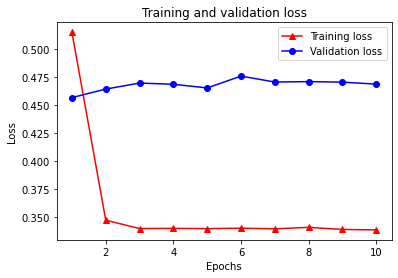

In [112]:
# plot training and validaiton loss over epochs
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

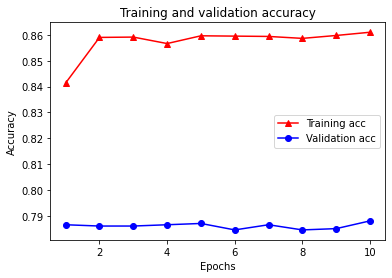

In [113]:
# plot training and validation accuracy over epochs
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

In [62]:
from spektral.datasets import QM9

In [63]:
dataset = QM9(amount=1000)  

44867584/44852087 [==============================] - 43s 1us/step
Loading QM9 dataset.
Reading SDF


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2878.29it/s]


In [ ]:
x[0]

Graph(n_nodes=107, n_node_features=128, n_edge_features=None, n_labels=1)